# Описание задачи

В этом задании необходимо достичь максимального качества предсказания, используя навыки полученные за 4 недели обучения

Кто достигнет максимального значения на тестовой выборке, получит *15 баллов*

Пожалуйста, оформляйте ноутбук аккуратно. Все выводы подписывайте, оформляйте заголовки.

Для справедливой оценки все должны использовать одну и ту же часть исходного датасета в качестве тестового набора данных. Используйте разбиение приведенное ниже


```
train_test_split(X, y, test_size = 0.3, random_state = 69)
```
И модель, с которой вы работаете - это линейная регрессия. Другие алгоритмы не используйте.

Метрика, которую вы должны максимизировать

```
r2_score(y_test, y_pred) и root_mean_squared_error(y_test, y_pred)
```

Целевая переменная - *count*

Обратите внимание на столбцы - 'casual', 'registered'. Эти столбцы в сумме дают целевую переменную, по этой причине их надо удалить. Они линейно зависимы.




Используйтие средства библиотеки sklearn, внимательно изучите ее. Существует огромное количество методов для выполнения каждого из этапов, не бойтесь использовать методы неприведенные в лекции

Этапы, которые необходимо проделать в работе для успешного достижения результата:
* EDA (Исследовать данные, понять с чем имеете дело, наработать идеи для генерации фичей и их обработки, обязательно корреляционные матрицы и графики с hue=классы объектов)
* Анализ выбросов и их обработка (в задачах классификации выброс - это объект с таким признаковым описанием, которое отличается очень сильно от типичного и больше соответствует другому классу)
* Генерация новых фичей
* Обработка пропусков (вы можете сгенерировать новые фичи с пропусками, тогда надо подумать об их обработке)
* Обработка категориальных признаков
* Масштабирование вещественных признаков
* Трансформирование таргета
* Нелинейные автоматические трансформации признаков (Kernel Trick, Transfomers)
* Подбор параметров модели (можете менять не только константы, но и оптимизационные алгоритмы и методы регуляризации)
* Отбор признаков
* Обязательно: Составление пайплайна обучения
* Обязательно: Постройте график зависимости y_pred от y_true в разбиении на test и train. Предсказание идеального алгоритма даст прямую y=x, посмотрите какой график получается у вас.

# Bike Sharing Demand
По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные.

### Библиотеки

In [16]:
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [17]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("bike_sharing_demand.csv").drop(columns=["casual", "registered"])

X = df.drop(columns=["count"])
y = df[["count"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
df


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129


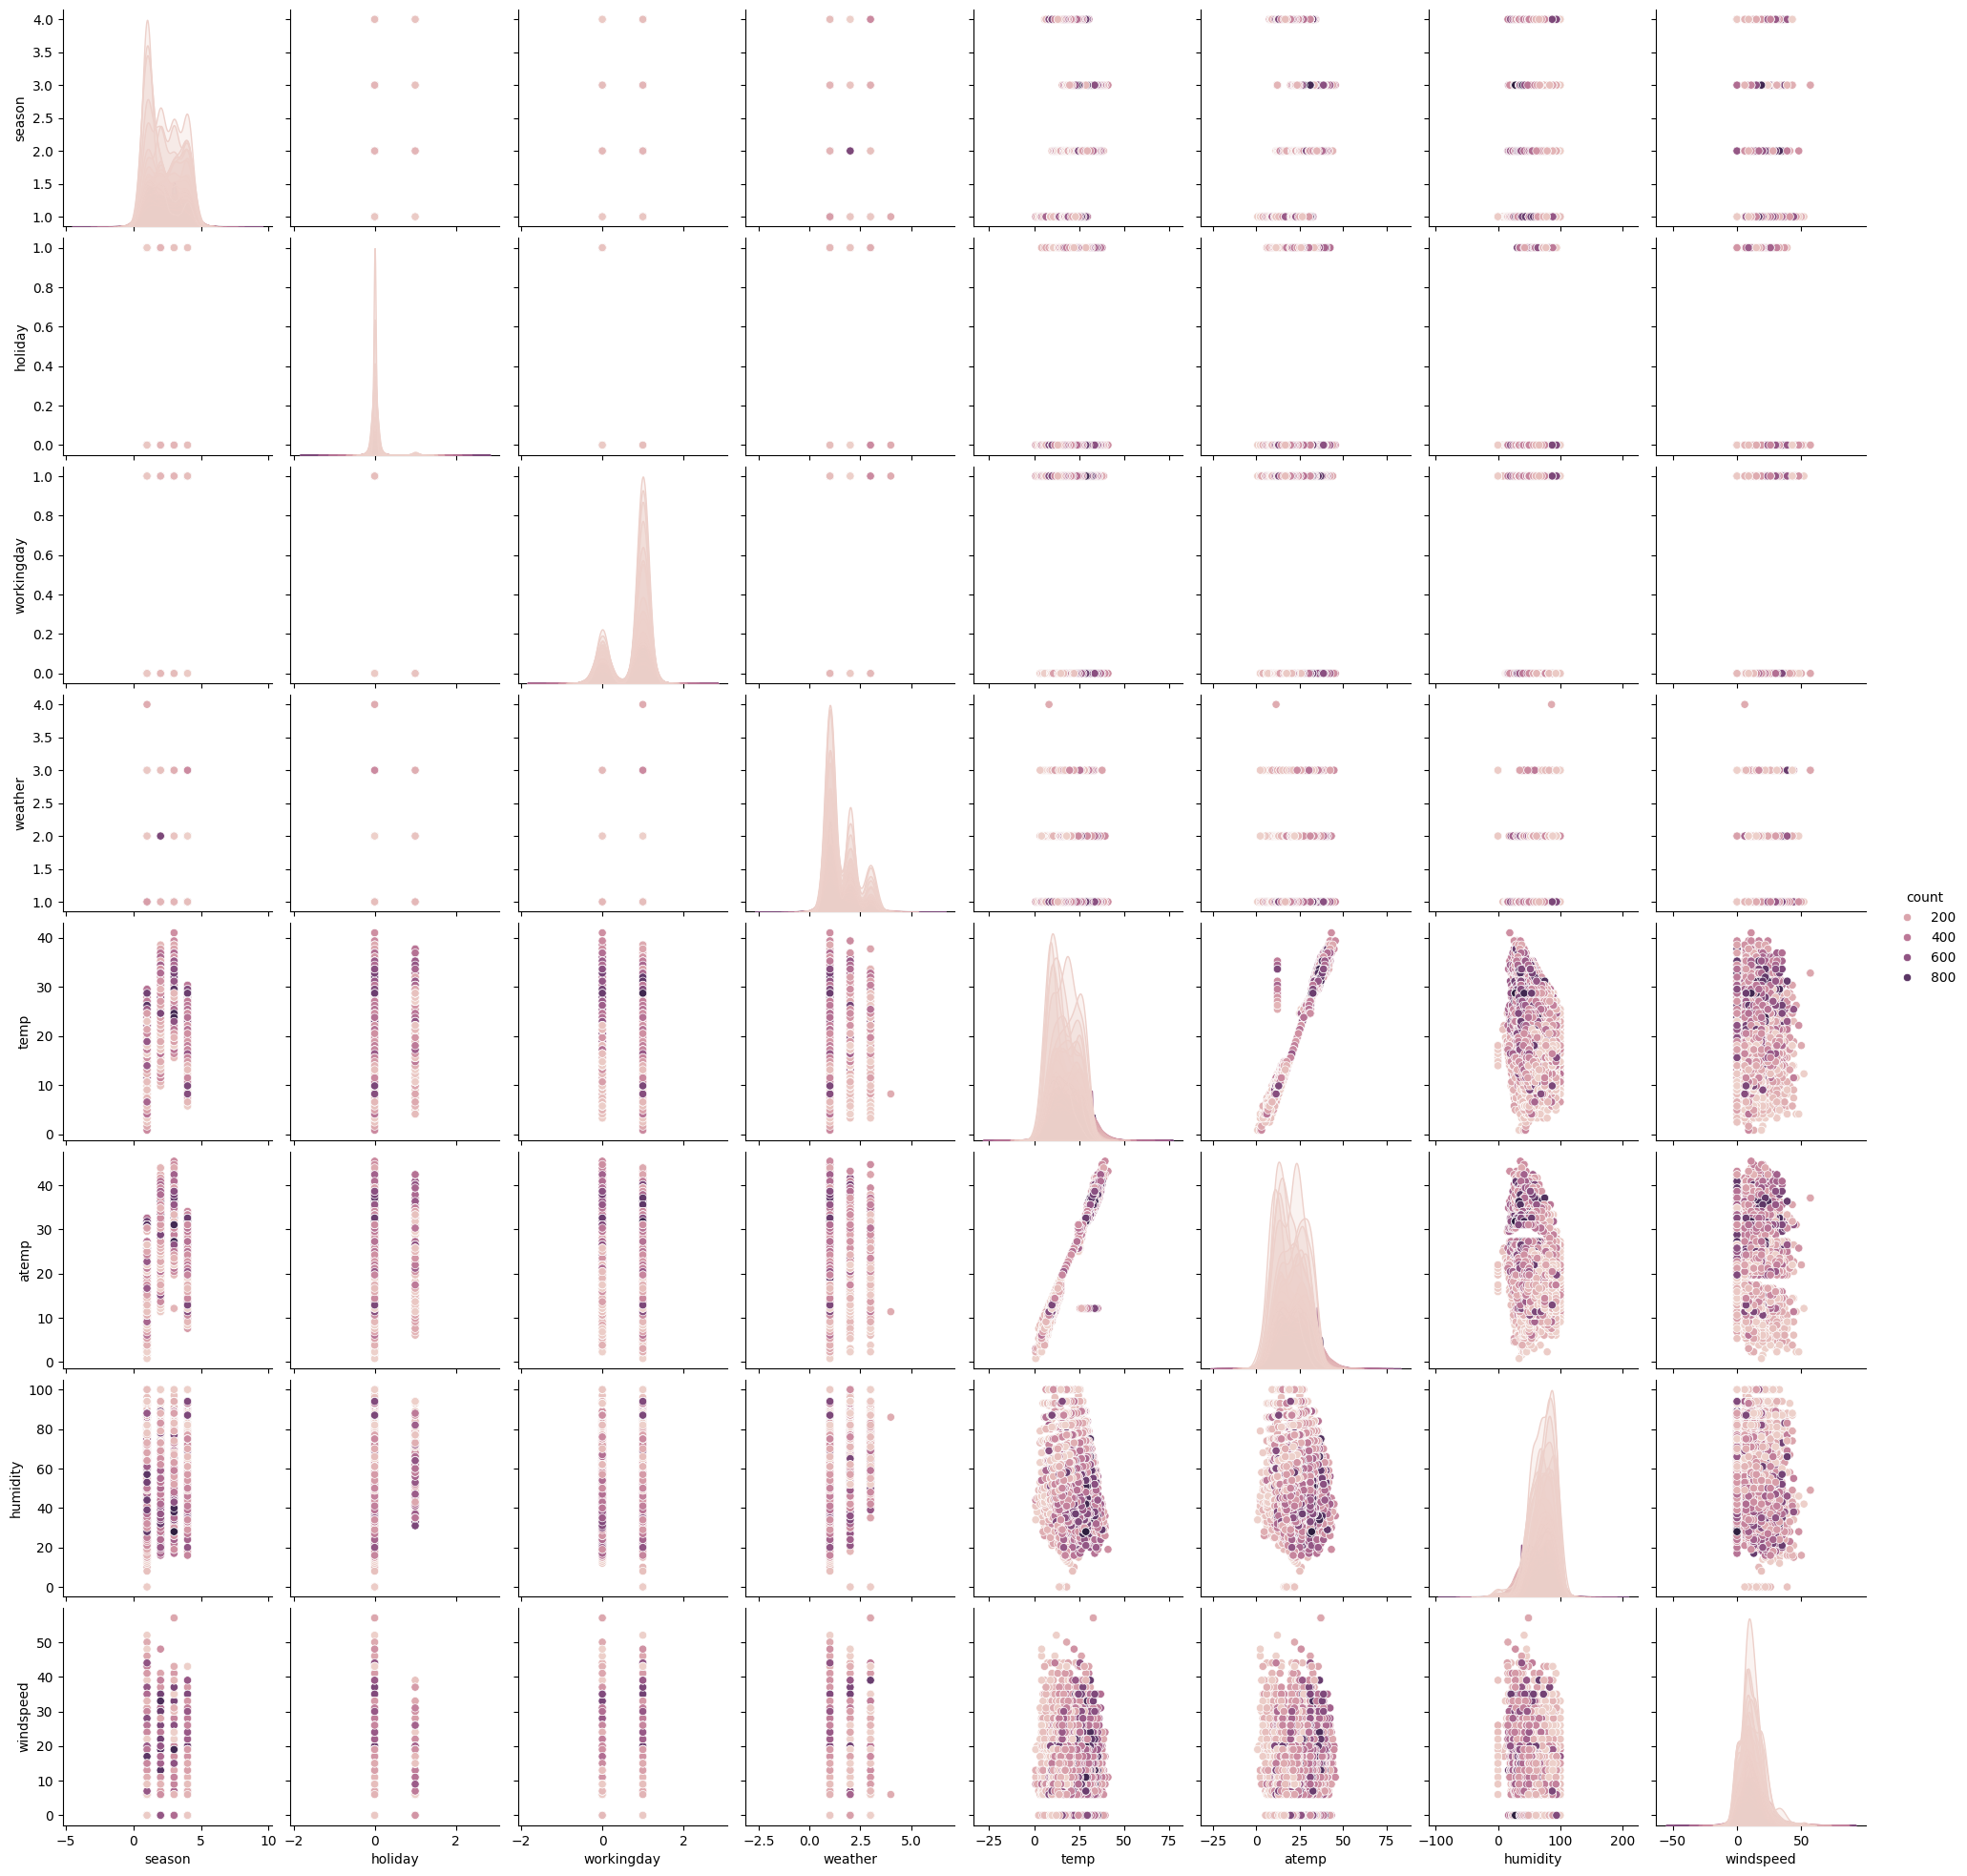

In [23]:
# sns.pairplot(data=df, hue="count")


Разделим фичи на 2 группы: численные и категориальные


In [19]:
numeric_cols = ['temp',
                'humidity',
                'windspeed']
cat_cols = ['season',
            'weather',
            'holiday',
            'workingday',
            'hour',
            'day',
            'month',
            'year',
            'day_type',
            'daytime']

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

Рассмотрим график плотносто распределения таргета и его же, только с логарифмированным таргетом, далее проведем анализ эффективности, какой таргет будет давать лучшую точность

<Axes: ylabel='Density'>

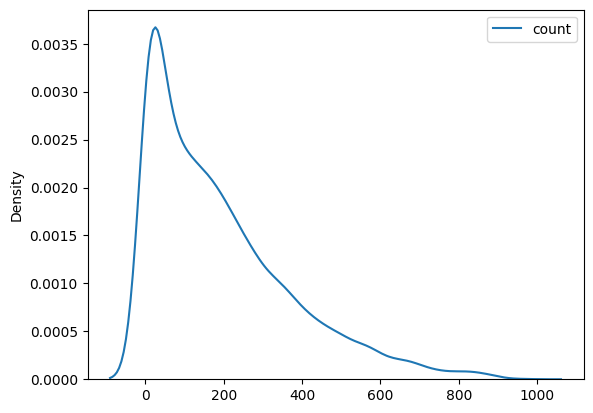

In [20]:
sns.kdeplot(data=y_train)

<Axes: ylabel='Density'>

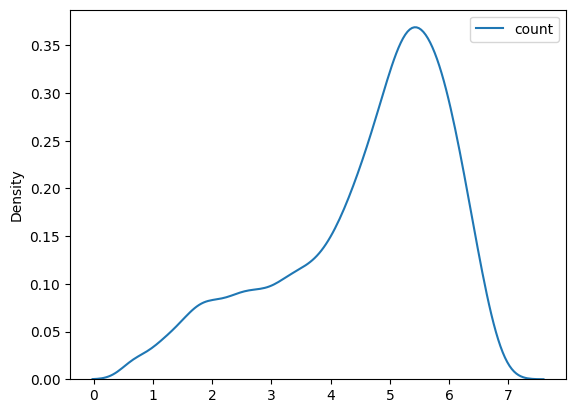

In [21]:
log_y_train = np.log1p(y_train)
sns.kdeplot(data=log_y_train)

Теперь изменим численные параметры, для начала рассмотрим их

<Axes: >

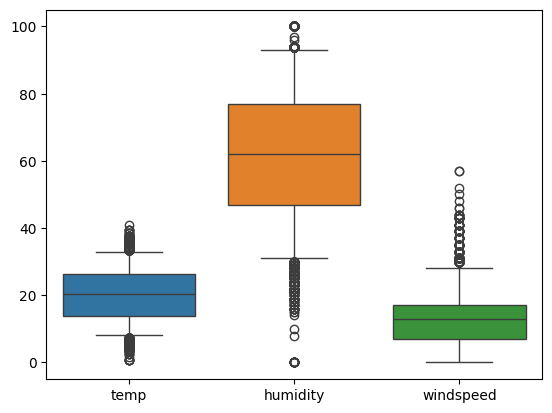

In [22]:
sns.boxplot(data=X_train[numeric_cols], whis=[5, 95])

Уберем выбросы, возьмем более щадящие пределы, т.к. при ограничениях строго по квантилям получаем, что убирается около 20%

In [26]:
both = pd.concat([X_train, y_train], axis=1)

for feature in ['temp', 'humidity', 'windspeed']:
  Q1 = X_train[feature].quantile(0.05)
  Q3 = X_train[feature].quantile(0.95)
  both = both[(1.7 * both[feature] >= Q1) & (both[feature] <= 1.7 * Q3)]

X_train = both[X_train.columns]
y_train = both[y_train.columns]


KeyboardInterrupt: 

In [27]:

from sklearn.base import BaseEstimator

class DateTimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        datetime_column = pd.to_datetime(X["datetime"])
        X = X.drop(columns=["datetime"])
        X["hour"] = datetime_column.dt.hour
        X["month"] = datetime_column.dt.month
        X["day_type"] = (X["workingday"] + 0.4) * (X["holiday"] + 0.6)
        X["comfort"] = (X["holiday"] + 0.5) * X["hour"]
        X["lazy"] = (X["workingday"] + 0.5) * X["hour"]
        X["feelings"] = (X["season"] ** 6) * X["hour"]
        return X


Рассмотрим данные фичи:
1. daytime - час дня, от 0 до 24, лучшим образом описывает спрос, тк кол-во арендованных велосипедов, что логично, зависит от времени суток.
2. month - месяц, от 1 до 12 - также проявляет себя в анализе, тк в холодные месяца спрос на аренду несколько падает
3. day_type - тип дня, который отражает, примерно, с какой вероятностью человек возьмет в аренду велосипед
4. comfort, lazy, feelings - производные от поля daytime, что также отражают привлекательность аренды велосипеда в конкретный день. Коэффициенты подобраны эмпирически

In [28]:

from typing import List, Tuple


class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, mult_list: List[Tuple[str, float]]):
        self.mult_list = mult_list

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col, mult in self.mult_list:
            X[col] = X[col] ** mult
        return X


Данный элемент пайплайна завязан возведении элементов в степень

In [29]:

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names: List[str]):
        self.columns_names = columns_names
        self.freq_dict = {}

    def fit(self, X, y=None):
        X_y = X.copy()
        X_y['count'] = y
        for column in self.columns_names:
            freq_counts = X_y.groupby(column)['count'].sum()
            max_val = freq_counts.max()
            self.freq_dict[column] = (freq_counts / max_val).to_dict()
        return self

    def transform(self, X):
        X = X.copy()
        for column in self.columns_names:
            X[column + "_freq"] = X[column].map(self.freq_dict[column]).fillna(0)
        return X


Данный элемент пайплайна вычислят вклад каждого значения в таргет, а затем нормирует все это к (0, 1)

# Код пайплайна

In [37]:

from typing import List, Tuple
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime

pipeline = Pipeline([
    ('datetime_features', DateTimeFeaturesExtractor()),
    ('frequency_encoder', FrequencyEncoder(["hour", "month", "temp", "holiday", "season", "workingday", "weather", "atemp", "humidity", "windspeed", "comfort", "lazy", "feelings", "day_type"])),
    ('scaler', FeatureScaler([
        ('season_freq', 10),
        ('holiday_freq', 10),
        ('day_type', 4),
        ('hour_freq', 1.5),
    ])),
    ('regressor', LinearRegression())
])

y_pred_train = pipeline.fit(X_train, y_train).predict(X_train)
y_pred_test = pipeline.fit(X_test, y_test).predict(X_test)

print("=TRAIN=")
print("r2_score:", r2_score(y_train, y_pred_train))
print("rmse:", mean_squared_error(y_train, y_pred_train) ** 0.5)

print("=TEST=")
print("r2_score:", r2_score(y_test, y_pred_test))
print("rmse:", mean_squared_error(y_test, y_pred_test) ** 0.5)


=TRAIN=
r2_score: 0.7288772228196607
rmse: 94.27834969879896
=TEST=
r2_score: 0.7063920412198803
rmse: 98.3449967025341


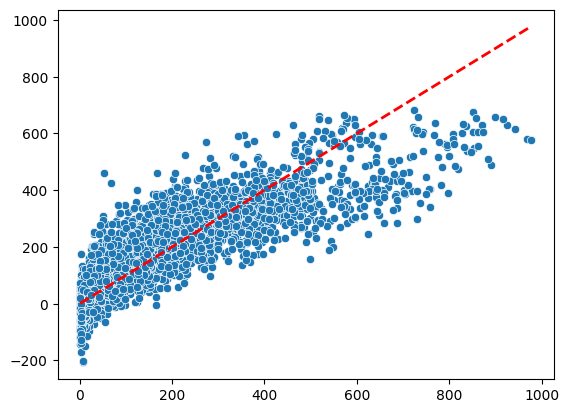

In [35]:
from matplotlib import pyplot as plt

sns.scatterplot(x=np.array(y_test).flatten(), y=y_pred_test.flatten())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.show()

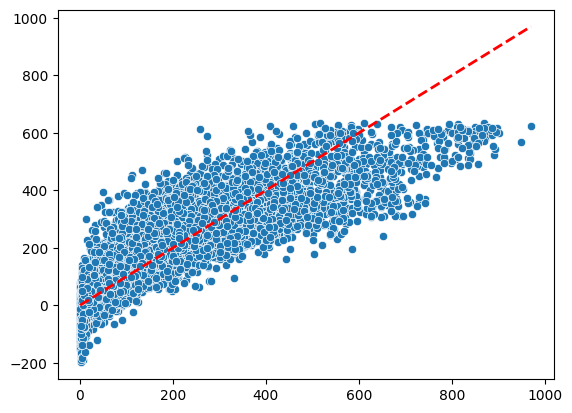

In [36]:

sns.scatterplot(x=np.array(y_train).flatten(), y=y_pred_train.flatten())
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', linewidth=2)
plt.show()
